<a href="https://colab.research.google.com/github/PatWoo23/CreditRiskAnalysis_Project/blob/main/XGBoostModel/1_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Identify Risky Customer

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/MIS561/CreditRecord0.xlsx")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              777715 non-null  int64 
 1   MONTHS_BALANCE  777715 non-null  int64 
 2   STATUS          777715 non-null  object
dtypes: int64(2), object(1)
memory usage: 17.8+ MB


,ID,MONTHS_BALANCE,STATUS
0,5008808,0,0
1,5008808,-1,X
2,5008808,-2,0
3,5008808,-3,X
4,5008808,-4,X


In [ ]:
print(df['ID'].nunique())

36457


In [ ]:
# Convert 'C' and 'X' to 0 in the STATUS column
df['STATUS'] = df['STATUS'].replace({'C': 0, 'X': 0})
df.head()

<ipython-input-16-668d03d3accb>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['STATUS'] = df['STATUS'].replace({'C': 0, 'X': 0})


,ID,MONTHS_BALANCE,STATUS
0,5008808,0,0
1,5008808,-1,0
2,5008808,-2,0
3,5008808,-3,0
4,5008808,-4,0


## Wrong output for version 1.


In [ ]:
#df[df['ID'] == 5008830]

,ID,MONTHS_BALANCE,STATUS,Total_Months,Phase
183,5008830,0,0,32,t2
184,5008830,-1,0,32,t2
185,5008830,-2,0,32,t2
186,5008830,-3,0,32,t2
187,5008830,-4,0,32,t2
188,5008830,-5,0,32,t2
189,5008830,-6,0,32,t2
190,5008830,-7,0,32,t2
191,5008830,-8,0,32,t2
192,5008830,-9,0,32,t2


In [ ]:
#Risk[Risk['ID'] == 5008830]

Phase,ID,Total Months,Average Status in Initial Phase,Average Status in Current Phase,Risky Customers
20,5008830,32,0.133333,0.0,0


## Version 2

In [ ]:
# Calculate Total Months
df['Total_Months'] = df.groupby('ID')['MONTHS_BALANCE'].transform('count')

# Check if there are any records with 'Total Months' equal to 1
records_with_one_month = df[df['Total_Months'] == 1]

if not records_with_one_month.empty:
    print("There are records with 'Total Months' equal to 1:")
    print(records_with_one_month)
else:
    print("No records with 'Total Months' equal to 1 found.")


There are records with 'Total Months' equal to 1:
             ID  MONTHS_BALANCE  STATUS  Total_Months
1524    5008939               0       0             1
2698    5009058               0       0             1
15914   5010290               0       0             1
15915   5010291               0       0             1
19597   5010595               0       0             1
...         ...             ...     ...           ...
773940  5149216               0       0             1
773952  5149218               0       0             1
775755  5149672               0       0             1
776231  5149854               0       0             1
777291  5150334               0       0             1

[341 rows x 4 columns]


In [ ]:
one_record = 341/777715
one_record

0.00043846396173405426

The amount is insignificant to the population.

In [ ]:
# copy df and drop rows where ['Total_Months'] = 1
df_copy = df.copy()
df_copy = df_copy[df_copy['Total_Months'] != 1]
df_copy.head()

,ID,MONTHS_BALANCE,STATUS,Total_Months
0,5008808,0,0,5
1,5008808,-1,0,5
2,5008808,-2,0,5
3,5008808,-3,0,5
4,5008808,-4,0,5


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777374 entries, 0 to 777714
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   ID              777374 non-null  int64
 1   MONTHS_BALANCE  777374 non-null  int64
 2   STATUS          777374 non-null  int64
 3   Total_Months    777374 non-null  int64
dtypes: int64(4)
memory usage: 29.7 MB


## Create ['Risky Customer']

In [ ]:
# Define a function to assign phases
def assign_phases(group):
    total_months = group['Total_Months'].iloc[0]  # Use precomputed Total_Months

    # Scenario 1: If Total_Months == 2
    if total_months == 2:
        phases = pd.Series(['t1', 't2'], index=group.sort_values('MONTHS_BALANCE').index)

    # Scenario 2: If Total_Months > 2
    else:
        sorted_group = group.sort_values('MONTHS_BALANCE')
        mid_point = total_months // 2  # Integer division for splitting

        if total_months % 2 == 0:
            # If even, split exactly into halves
            t1_indices = sorted_group.iloc[:mid_point].index
            t2_indices = sorted_group.iloc[mid_point:].index
        else:
            # If odd, assign the middle month to t2 (can modify to assign to t1 if desired)
            t1_indices = sorted_group.iloc[:mid_point].index
            t2_indices = sorted_group.iloc[mid_point:].index

        phases = pd.Series(index=group.index, dtype=str)
        phases.loc[t1_indices] = 't1'
        phases.loc[t2_indices] = 't2'

    return phases

# Apply the phase assignment function
df_copy['Phase'] = df_copy.groupby('ID').apply(assign_phases).reset_index(level=0, drop=True)


The calculated risk for ID 5008830 is:
          ID  MONTHS_BALANCE  STATUS  Total_Months Phase
183  5008830               0       0            32    t2
184  5008830              -1       0            32    t2
185  5008830              -2       0            32    t2
186  5008830              -3       0            32    t2
187  5008830              -4       0            32    t2
188  5008830              -5       0            32    t2
189  5008830              -6       0            32    t2
190  5008830              -7       0            32    t2
191  5008830              -8       0            32    t2
192  5008830              -9       0            32    t2
193  5008830             -10       0            32    t2
194  5008830             -11       0            32    t2
195  5008830             -12       0            32    t2
196  5008830             -13       0            32    t2
197  5008830             -14       0            32    t2
198  5008830             -15       0            3

<ipython-input-25-0500ab7bc3b0>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy['Phase'] = df_copy.groupby('ID').apply(assign_phases).reset_index(level=0, drop=True)


In [ ]:
# Calculate Average Status in Each Phase
phase_avg = (
    df_copy.groupby(['ID', 'Phase'])['STATUS']
    .mean()
    .unstack(fill_value=0)
    .rename(columns={'t1': 'Average Status in Initial Phase', 't2': 'Average Status in Current Phase'})
)

# Merge results back to get Total Months and Risky Classification
result = phase_avg.reset_index()
result['Risky Customers'] = (result['Average Status in Current Phase'] > result['Average Status in Initial Phase']).astype(int)

# Create a new DataFrame Risk with the required columns
Risk = result[['ID', 'Average Status in Initial Phase', 'Average Status in Current Phase', 'Risky Customers']]

# For testing: View the result
record = result[result['ID'] == 5008830]
print(f"The calculated risk for ID 5008830 is:\n{record}")
print("The actual risk for ID 5008830 is 0.")

# Check one-record rows
print(result[result['ID'] == 5008939])


The calculated risk for ID 5008830 is:
Phase       ID  Average Status in Initial Phase  \
20     5008830                            0.125   

Phase  Average Status in Current Phase  Risky Customers  
20                                 0.0                0  
The actual risk for ID 5008830 is 0.
Empty DataFrame
Columns: [ID, Average Status in Initial Phase, Average Status in Current Phase, Risky Customers]
Index: []


In [ ]:
customers = df_copy['ID'].nunique() -314
print(f"Number of customers: {customers}")
result.info()

Number of customers: 35802
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36116 entries, 0 to 36115
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               36116 non-null  int64  
 1   Average Status in Initial Phase  36116 non-null  float64
 2   Average Status in Current Phase  36116 non-null  float64
 3   Risky Customers                  36116 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 1.1 MB


In [ ]:
print(result['ID'].nunique())


36116


Number matches with the calculation: 36457 - 341.

In [ ]:
# Export the Risk DataFrame as an Excel file
Risk.to_excel("/content/drive/MyDrive/MIS561/Risk1.xlsx" , index=False)

print(f"'Risk' DataFrame saved to {output_file}.")


'Risk' DataFrame saved to Risk_Customers.xlsx.


# Customer Details

In [ ]:
dfc = pd.read_excel("/content/drive/MyDrive/MIS561/Customers0.xlsx")
dfc.info()
dfc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5041856,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2
1,5026168,M,Y,Y,0,225000.0,Pensioner,Higher education,Married,House / apartment,-24166,365243,1,0,0,0,NaN,2
2,5035920,F,Y,Y,1,180000.0,Commercial associate,Incomplete higher,Civil marriage,House / apartment,-15445,-706,1,0,0,0,Laborers,3
3,5041710,M,Y,Y,3,180000.0,Working,Secondary / secondary special,Married,House / apartment,-14192,-824,1,1,1,0,High skill tech staff,5
4,5045517,M,Y,N,1,180000.0,Working,Secondary / secondary special,Married,House / apartment,-11498,-4491,1,0,0,0,NaN,3


In [ ]:
dfc.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [ ]:
unique_values = {
    'CODE_GENDER': dfc['CODE_GENDER'].unique(),
    'FLAG_OWN_CAR': dfc['FLAG_OWN_CAR'].unique(),
    'FLAG_OWN_REALTY': dfc['FLAG_OWN_REALTY'].unique()
}
unique_values

{'CODE_GENDER': array(['M', 'F'], dtype=object),
 'FLAG_OWN_CAR': array(['Y', 'N'], dtype=object),
 'FLAG_OWN_REALTY': array(['N', 'Y'], dtype=object)}

In [ ]:
# for checking
dfc.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5041856,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2
1,5026168,M,Y,Y,0,225000.0,Pensioner,Higher education,Married,House / apartment,-24166,365243,1,0,0,0,NaN,2
2,5035920,F,Y,Y,1,180000.0,Commercial associate,Incomplete higher,Civil marriage,House / apartment,-15445,-706,1,0,0,0,Laborers,3
3,5041710,M,Y,Y,3,180000.0,Working,Secondary / secondary special,Married,House / apartment,-14192,-824,1,1,1,0,High skill tech staff,5
4,5045517,M,Y,N,1,180000.0,Working,Secondary / secondary special,Married,House / apartment,-11498,-4491,1,0,0,0,NaN,3


In [ ]:
# Copy dfc to dfc1
dfc1 = dfc.copy()

# Convert 'CODE_GENDER' to 1 (for 'M') and 0 (for 'F')
dfc1['CODE_GENDER'] = dfc1['CODE_GENDER'].apply(lambda x: 1 if x == 'M' else 0)

# Convert 'FLAG_OWN_CAR' to 1 (for 'Y') and 0 (for 'N')
dfc1['FLAG_OWN_CAR'] = dfc1['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)

# Convert 'FLAG_OWN_REALTY' to 1 (for 'Y') and 0 (for 'N')
dfc1['FLAG_OWN_REALTY'] = dfc1['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)

# Display the updated DataFrame
dfc1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5041856,1,1,0,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2
1,5026168,1,1,1,0,225000.0,Pensioner,Higher education,Married,House / apartment,-24166,365243,1,0,0,0,NaN,2
2,5035920,0,1,1,1,180000.0,Commercial associate,Incomplete higher,Civil marriage,House / apartment,-15445,-706,1,0,0,0,Laborers,3
3,5041710,1,1,1,3,180000.0,Working,Secondary / secondary special,Married,House / apartment,-14192,-824,1,1,1,0,High skill tech staff,5
4,5045517,1,1,0,1,180000.0,Working,Secondary / secondary special,Married,House / apartment,-11498,-4491,1,0,0,0,NaN,3


In [ ]:
# Convert day values to year values in postive values
dfc1['DAYS_BIRTH'] = (dfc['DAYS_BIRTH'].abs() / 365).round(0).astype(int)
dfc1['DAYS_EMPLOYED'] = (dfc['DAYS_EMPLOYED'].abs() / 365).round(1)

# Rename columns 'DAYS_BIRTH' to 'Age' and 'DAYS_EMPLOYED' to 'Employment Years'
dfc1.rename(columns={'DAYS_BIRTH': 'Age', 'DAYS_EMPLOYED': 'Employment Years'}, inplace=True)

print(dfc1[['ID', 'Age', 'Employment Years']].head())

        ID  Age  Employment Years
0  5041856   60            1000.7
1  5026168   66            1000.7
2  5035920   42               1.9
3  5041710   39               2.3
4  5045517   32              12.3


In [ ]:
unique_values2 = {
    'NAME_INCOME_TYPE': dfc1['NAME_INCOME_TYPE'].unique(),
    'NAME_EDUCATION_TYPE': dfc1['NAME_EDUCATION_TYPE'].unique(),
    'NAME_FAMILY_STATUS': dfc1['NAME_FAMILY_STATUS'].unique(),
    'NAME_HOUSING_TYPE': dfc1['NAME_HOUSING_TYPE'].unique()
}
unique_values2

{'NAME_INCOME_TYPE': array(['Pensioner', 'Commercial associate', 'Working', 'State servant',
        'Student'], dtype=object),
 'NAME_EDUCATION_TYPE': array(['Secondary / secondary special', 'Higher education',
        'Incomplete higher', 'Lower secondary', 'Academic degree'],
       dtype=object),
 'NAME_FAMILY_STATUS': array(['Civil marriage', 'Married', 'Single / not married', 'Separated',
        'Widow'], dtype=object),
 'NAME_HOUSING_TYPE': array(['House / apartment', 'Rented apartment', 'Municipal apartment',
        'With parents', 'Office apartment', 'Co-op apartment'],
       dtype=object)}

In [ ]:
# For checking
filtered_df = dfc1[dfc1['NAME_FAMILY_STATUS'].isin(['Civil marriage'])]
filtered_df[['ID', 'NAME_FAMILY_STATUS']].head(10)

,ID,NAME_FAMILY_STATUS
0,5041856,Civil marriage
2,5035920,Civil marriage
6,5095015,Civil marriage
10,5116406,Civil marriage
18,5132567,Civil marriage
28,5087482,Civil marriage
29,5087483,Civil marriage
30,5087730,Civil marriage
31,5096646,Civil marriage
50,5088930,Civil marriage


In [ ]:
# Create a list of IDs from the filtered DataFrame
ID_CivilMarriage = filtered_df['ID'].tolist()

print(ID_CivilMarriage)
print(len(ID_CivilMarriage))

[5041856, 5035920, 5095015, 5116406, 5132567, 5087482, 5087483, 5087730, 5096646, 5088930, 5087727, 5050539, 5096509, 5116517, 5150013, 5035921, 5035922, 5044749, 5135902, 5149661, 5009838, 5035682, 5041168, 5050545, 5054285, 5028817, 5132657, 5021645, 5037226, 5044642, 5053238, 5021850, 5045679, 5088430, 5096220, 5117215, 5046007, 5085712, 5095872, 5132568, 5033601, 5041985, 5041988, 5050549, 5087900, 5087914, 5089377, 5095974, 5116454, 5117500, 5010007, 5028326, 5050484, 5090820, 5091116, 5117909, 5010734, 5028360, 5036672, 5088932, 5132743, 5046360, 5048026, 5078901, 5118491, 5009884, 5010737, 5010742, 5050534, 5050540, 5050542, 5089376, 5132653, 5135968, 5149667, 5009285, 5023173, 5085776, 5087879, 5090538, 5090702, 5142465, 5150029, 5033556, 5041638, 5050705, 5058464, 5078904, 5087498, 5087880, 5088928, 5089142, 5089594, 5096649, 5125264, 5126727, 5148672, 5149799, 5021851, 5024297, 5029414, 5044873, 5087484, 5089121, 5096508, 5125412, 5148455, 5023917, 5024295, 5041165, 5041854, 

In [ ]:
# Group 'Civil marriage' and 'Married' as 'Married'
dfc1['NAME_FAMILY_STATUS'] = dfc1['NAME_FAMILY_STATUS'].replace({'Civil marriage': 'Married'})

# Filter and display the rows where 'ID' is in the ID_CivilMarriage list
filtered_dfc1 = dfc1[dfc1['ID'].isin(ID_CivilMarriage)]
filtered_dfc1[['ID', 'NAME_FAMILY_STATUS']].head(10)

,ID,NAME_FAMILY_STATUS
0,5041856,Married
2,5035920,Married
6,5095015,Married
10,5116406,Married
18,5132567,Married
28,5087482,Married
29,5087483,Married
30,5087730,Married
31,5096646,Married
50,5088930,Married


In [ ]:
# For checking
many_children = dfc1.loc[dfc1['CNT_CHILDREN'] >= 7]
many_children[['ID', 'CNT_CHILDREN']].head(10)

,ID,CNT_CHILDREN
8260,5118331,7
10203,5118330,7
21356,5061207,14
21357,5061210,14
21358,5061211,14
28839,5105054,19


In [ ]:
dfc1.columns


Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NUM_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'Age', 'Employment Years',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [ ]:
# Step 1 & Step 2: Find rows where 'CNT_CHILDREN' is 7 or above and group them to 7
dfc1.loc[dfc1['NUM_CHILDREN'] >= 7, 'NUM_CHILDREN'] = 7

# Step 3: Put the selected group 'ID' into a list called ID_many_children
ID_many_children = dfc1[dfc1['NUM_CHILDREN'] == 7]['ID'].tolist()

# Step 4: Rename 'CNT_CHILDREN' to 'NUM_CHILDREN'
#dfc1.rename(columns={'CNT_CHILDREN': 'NUM_CHILDREN'}, inplace=True)

# Step 5: Display 'NUM_CHILDREN' where 'ID' is in ID_many_children
filtered_dfc2 = dfc1[dfc1['ID'].isin(ID_many_children)]

# Display the first 10 rows of 'ID' and 'NUM_CHILDREN'
print(filtered_dfc2[['ID', 'NUM_CHILDREN']].head(10))


            ID  NUM_CHILDREN
8260   5118331             7
10203  5118330             7
21356  5061207             7
21357  5061210             7
21358  5061211             7
28839  5105054             7


In [ ]:
# For checking
big_family = dfc1.loc[dfc1['CNT_FAM_MEMBERS'] >= 7]
print(big_family[['ID', 'CNT_FAM_MEMBERS']].head(10))

           ID  CNT_FAM_MEMBERS
1238  5135539                7
1632  5135536                7
3370  5135537                7
4878  5135534                7
5127  5135535                7
5402  5135540                7
7818  5105605                7
8214  5105609                7
8260  5118331                9
8607  5105606                7


In [ ]:
# Step 1 & Step 2: Find rows where 'CNT_FAM_MEMBERS' is 7 or above and group them to 7
dfc1.loc[dfc1['CNT_FAM_MEMBERS'] > 7, 'CNT_FAM_MEMBERS'] = 7

# Step 3: Put the selected group 'ID' into a list called ID_many_family_members
ID_many_family_members = dfc1[dfc1['CNT_FAM_MEMBERS'] == 7]['ID'].tolist()

# Step 4: Rename 'CNT_FAM_MEMBERS' to 'NUM_FAMILY_MEMBERS'
dfc1.rename(columns={'CNT_FAM_MEMBERS': 'NUM_FAMILY_MEMBERS'}, inplace=True)

# Step 5: Display 'NUM_FAMILY_MEMBERS' where 'ID' is in ID_many_family_members
filtered_dfc2 = dfc1[dfc1['ID'].isin(ID_many_family_members)]

# Step 6: Checking
print(filtered_dfc2[['ID', 'NUM_FAMILY_MEMBERS']].head(10))

           ID  NUM_FAMILY_MEMBERS
1238  5135539                   7
1632  5135536                   7
3370  5135537                   7
4878  5135534                   7
5127  5135535                   7
5402  5135540                   7
7818  5105605                   7
8214  5105609                   7
8260  5118331                   7
8607  5105606                   7


In [ ]:
print(dfc1.head(10))
print(dfc1.tail())

        ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  NUM_CHILDREN  \
0  5041856            1             1                0             0   
1  5026168            1             1                1             0   
2  5035920            0             1                1             1   
3  5041710            1             1                1             3   
4  5045517            1             1                0             1   
5  5079234            0             0                1             0   
6  5095015            0             0                1             0   
7  5095477            0             0                1             0   
8  5096579            0             0                0             0   
9  5113556            1             1                1             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          112500.0             Pensioner  Secondary / secondary special   
1          225000.0             Pensioner              

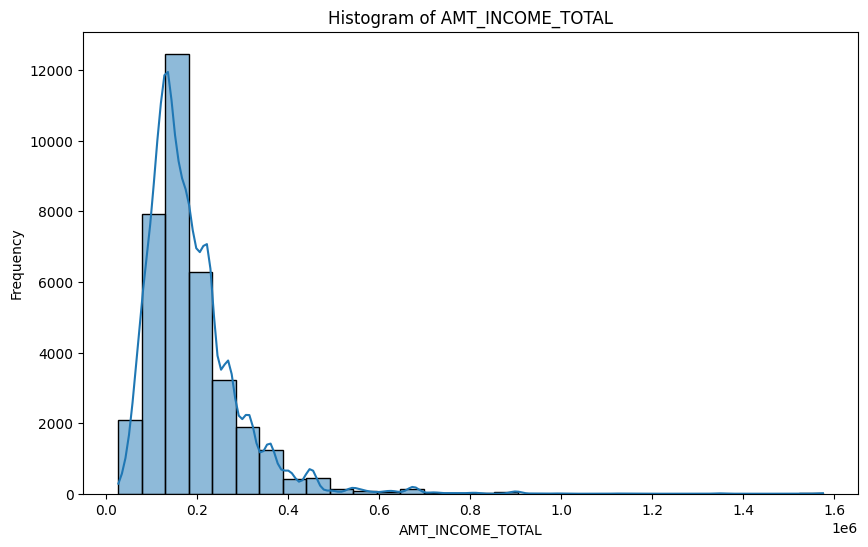

In [ ]:
# Check Income range and distribution
# Plot a histogram of 'AMT_INCOME_TOTAL' using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(dfc1['AMT_INCOME_TOTAL'], bins=30, kde=True)

# Set plot labels and title
plt.xlabel('AMT_INCOME_TOTAL')
plt.ylabel('Frequency')
plt.title('Histogram of AMT_INCOME_TOTAL')

# Show the plot
plt.show()

In [ ]:
# Define income bands based on the provided ranges
bins = [0, 15000, 25000, 35000, 50000, 75000, 100000, 150000, 200000, float('inf')]
labels = [
    'Under $15,000',
    '$15,000 to $24,999',
    '$25,000 to $34,999',
    '$35,000 to $49,999',
    '$50,000 to $74,999',
    '$75,000 to $99,999',
    '$100,000 to $149,999',
    '$150,000 to $199,999',
    '$200,000 and over'
]

# Group income using pd.cut()
dfc1['INCOME_BAND'] = pd.cut(dfc1['AMT_INCOME_TOTAL'], bins=bins, labels=labels, right=True)

# Display the count of each income band
income_band_counts = dfc1['INCOME_BAND'].value_counts()

# Print income band counts
print(income_band_counts)

INCOME_BAND
$200,000 and over       13474
$100,000 to $149,999    10236
$150,000 to $199,999     7661
$75,000 to $99,999       3323
$50,000 to $74,999       1442
$35,000 to $49,999        272
$25,000 to $34,999         49
Under $15,000               0
$15,000 to $24,999          0
Name: count, dtype: int64


In [ ]:
# Calculate the percentage of total for each income band
income_band_percentages = (income_band_counts / len(dfc1)) * 100

# Combine the counts and percentages into a single DataFrame for display
income_band_summary = pd.DataFrame({
    'Count': income_band_counts,
    'Percentage': income_band_percentages
})

# Display the summary
print(income_band_summary)

                      Count  Percentage
INCOME_BAND                            
$200,000 and over     13474   36.958609
$100,000 to $149,999  10236   28.076913
$150,000 to $199,999   7661   21.013797
$75,000 to $99,999     3323    9.114848
$50,000 to $74,999     1442    3.955345
$35,000 to $49,999      272    0.746084
$25,000 to $34,999       49    0.134405
Under $15,000             0    0.000000
$15,000 to $24,999        0    0.000000


In [ ]:
print(dfc1[['ID', 'AMT_INCOME_TOTAL', 'INCOME_BAND']])

            ID  AMT_INCOME_TOTAL           INCOME_BAND
0      5041856          112500.0  $100,000 to $149,999
1      5026168          225000.0     $200,000 and over
2      5035920          180000.0  $150,000 to $199,999
3      5041710          180000.0  $150,000 to $199,999
4      5045517          180000.0  $150,000 to $199,999
...        ...               ...                   ...
36452  5149828          315000.0     $200,000 and over
36453  5149834          157500.0  $150,000 to $199,999
36454  5149838          157500.0  $150,000 to $199,999
36455  5150049          283500.0     $200,000 and over
36456  5150337          112500.0  $100,000 to $149,999

[36457 rows x 3 columns]


The distribution is too skewed.

The US gov't banding doesn't work with this dataset.

Suggestions:

| **Revised Band**            | **Range**             |
|-----------------------------|-----------------------|
| **Low Income**              | $0 - $74,999         |
| **Moderate Income**         | $75,000 - $149,999   |
| **High Income**             | $150,000 - $199,999  |
| **Very High Income**        | $200,000 - $299,999  |
| **Ultra High Income**       | $300,000 and over    |


In [ ]:
# Define income bands based on the provided ranges
bins = [0, 75000, 150000, 200000, 300000, float('inf')]
labels = [
    'Under $75,000',
    '$75,000 to $149,999',
    '$150,000 to $199,999',
    '$200,000 to $299,999',
    '$300,000 and over'
]

# Group income using pd.cut()
dfc1['NEW_INCOME_BAND'] = pd.cut(dfc1['AMT_INCOME_TOTAL'], bins=bins, labels=labels, right=True)

# Display the count of each income band
income_band_counts2 = dfc1['NEW_INCOME_BAND'].value_counts()

# Calculate the percentage of total for each income band
income_band_percentages2 = (income_band_counts2 / len(dfc1)) * 100

# Combine the counts and percentages into a single DataFrame for display
income_band_summary2 = pd.DataFrame({
    'Count': income_band_counts2,
    'Percentage': income_band_percentages2
})

# Display the summary
print(income_band_summary2)


                      Count  Percentage
NEW_INCOME_BAND                        
$75,000 to $149,999   13559   37.191760
$200,000 to $299,999   9645   26.455825
$150,000 to $199,999   7661   21.013797
$300,000 and over      3829   10.502784
Under $75,000          1763    4.835834


In [ ]:
print(dfc1[100:120])

          ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  NUM_CHILDREN  \
100  5105211            0             0                0             0   
101  5116886            0             0                0             3   
102  5105989            0             1                0             0   
103  5114305            1             1                0             0   
104  5115599            0             0                0             1   
105  5143488            1             0                1             1   
106  5010866            1             1                1             1   
107  5025781            0             0                1             1   
108  5026367            1             0                1             1   
109  5033488            0             0                0             0   
110  5033797            0             1                1             0   
111  5035715            1             1                1             0   
112  5035877            0             

In [ ]:
# Export the dfc1 DataFrame as an Excel file
output_file = "/content/drive/MyDrive/MIS561/Customers1.xlsx"
dfc1.to_excel(output_file, index=False)

print(f"'dfc1' DataFrame saved to {output_file}.")

'dfc1' DataFrame saved to /content/drive/MyDrive/MIS561/Customers1.xlsx.


## Employment Year Imputation

In [ ]:
dfc2 = pd.read_excel("/content/drive/MyDrive/MIS561/Customers1.xlsx")
print(dfc2.info())
print(dfc2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  int64  
 2   FLAG_OWN_CAR         36457 non-null  int64  
 3   FLAG_OWN_REALTY      36457 non-null  int64  
 4   NUM_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment Years     36457 non-null  float64
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [ ]:
print(dfc2.columns)

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NUM_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'Age', 'Employment Years',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'NUM_FAMILY_MEMBERS', 'INCOME_BAND',
       'NEW_INCOME_BAND'],
      dtype='object')


In [ ]:
filtered_emp = dfc2[dfc2['Employment Years'] == 1000.700000]
print(filtered_emp.describe())

                 ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  NUM_CHILDREN  \
count  6.135000e+03  6135.000000   6135.000000      6135.000000   6135.000000   
mean   5.074650e+06     0.146699      0.209780         0.769356      0.050204   
std    4.173749e+04     0.353835      0.407185         0.421279      0.282790   
min    5.008812e+06     0.000000      0.000000         0.000000      0.000000   
25%    5.038624e+06     0.000000      0.000000         1.000000      0.000000   
50%    5.067042e+06     0.000000      0.000000         1.000000      0.000000   
75%    5.113456e+06     0.000000      0.000000         1.000000      0.000000   
max    5.150423e+06     1.000000      1.000000         1.000000      3.000000   

       AMT_INCOME_TOTAL          Age  Employment Years  FLAG_MOBIL  \
count       6135.000000  6135.000000      6.135000e+03      6135.0   
mean      148590.916137    59.659495      1.000700e+03         1.0   
std        76593.371512     5.322279      1.114222e-10      

Impute ['Employment Years'] using the median ['Employment Years'] of customers with the same age.

In [ ]:
dfc2[dfc2['Employment Years'] == 1000.700000].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6135 entries, 0 to 36439
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6135 non-null   int64  
 1   CODE_GENDER          6135 non-null   int64  
 2   FLAG_OWN_CAR         6135 non-null   int64  
 3   FLAG_OWN_REALTY      6135 non-null   int64  
 4   NUM_CHILDREN         6135 non-null   int64  
 5   AMT_INCOME_TOTAL     6135 non-null   float64
 6   NAME_INCOME_TYPE     6135 non-null   object 
 7   NAME_EDUCATION_TYPE  6135 non-null   object 
 8   NAME_FAMILY_STATUS   6135 non-null   object 
 9   NAME_HOUSING_TYPE    6135 non-null   object 
 10  Age                  6135 non-null   int64  
 11  Employment Years     6135 non-null   float64
 12  FLAG_MOBIL           6135 non-null   int64  
 13  FLAG_WORK_PHONE      6135 non-null   int64  
 14  FLAG_PHONE           6135 non-null   int64  
 15  FLAG_EMAIL           6135 non-null   int64

## Wrongly delete some outputs for version 1

In [ ]:
# Step 1. For each 'Age' of the affected customers, compute the median 'Employment Years' of non-affected customers with the same 'Age'
for age in filtered_emp['Age'].unique():
    median_employment_years = dfc2[
        (dfc2['Age'] == age) &
        (dfc2['Employment Years'] != 1000.7)
    ]['Employment Years'].median()

    # Step 2. Impute the affected rows with the calculated median
    dfc2.loc[
        (dfc2['Employment Years'] == 1000.7) &
        (dfc2['Age'] == age),
        'Employment Years'
    ] = median_employment_years

# Checking
print(dfc2[dfc2['ID'].isin(filtered_emp['ID'])][['ID', 'Employment Years']])

            ID  Employment Years
0      5041856               9.9
1      5026168               6.7
8      5096579               7.6
10     5116406               6.5
14     5053152               5.9
...        ...               ...
36408  5126278               7.8
36418  5139446               7.8
36432  5145690               6.6
36434  5145817               9.9
36439  5148602               5.8

[6135 rows x 2 columns]


In [ ]:
print(dfc2.describe())

                 ID   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
count  3.645700e+04  36457.000000  36457.000000     36457.000000   
mean   5.078227e+06      0.329895      0.379708         0.672189   
std    4.187524e+04      0.470181      0.485321         0.469422   
min    5.008804e+06      0.000000      0.000000         0.000000   
25%    5.042028e+06      0.000000      0.000000         0.000000   
50%    5.074614e+06      0.000000      0.000000         1.000000   
75%    5.115396e+06      1.000000      1.000000         1.000000   
max    5.150487e+06      1.000000      1.000000         1.000000   

       NUM_CHILDREN  AMT_INCOME_TOTAL           Age  Employment Years  \
count  36457.000000      3.645700e+04  36457.000000      36363.000000   
mean       0.429410      1.866857e+05     43.777382          7.363446   
std        0.728857      1.017892e+05     11.519211          5.949189   
min        0.000000      2.700000e+04     21.000000          0.000000   
25%        0.000000   

## Wrong Version 2

In [ ]:
# Step 1: Create a new column 'New Employment Year' and copy 'Employment Years' where Employment Years != 1000.7
dfc2['New Employment Year'] = dfc2['Employment Years']

# Step 2: For each 'Age' of the affected customers, compute the median 'Employment Years' of non-affected customers with the same 'Age'
for age in dfc2.loc[dfc2['Employment Years'] == 1000.7, 'Age'].unique():
    median_employment_years = dfc2[
        (dfc2['Age'] == age) &
        (dfc2['Employment Years'] != 1000.7)
    ]['Employment Years'].median()

    # Step 3: Impute the affected rows in 'New Employment Year' with the calculated median
    dfc2.loc[
        (dfc2['Employment Years'] == 1000.7) &
        (dfc2['Age'] == age),
        'New Employment Year'
    ] = median_employment_years

# Step 4: Check only rows where 'ID' is in the filtered_emp DataFrame
filtered_emp = dfc2[dfc2['Employment Years'] == 1000.7]
filtered_rows = dfc2[dfc2['ID'].isin(filtered_emp['ID'])][['ID', 'Employment Years', 'New Employment Year']]

# For checking
print(filtered_rows)


            ID  Employment Years  New Employment Year
0      5041856            1000.7                  9.9
1      5026168            1000.7                  6.7
8      5096579            1000.7                  7.6
10     5116406            1000.7                  6.5
14     5053152            1000.7                  5.9
...        ...               ...                  ...
36408  5126278            1000.7                  7.8
36418  5139446            1000.7                  7.8
36432  5145690            1000.7                  6.6
36434  5145817            1000.7                  9.9
36439  5148602            1000.7                  5.8

[6135 rows x 3 columns]


In [ ]:
dfc2['New Employment Year'].describe()

,New Employment Year
count,36363.000000
mean,7.363446
std,5.949189
min,0.000000
25%,3.200000
50%,6.400000
75%,9.400000
max,43.000000


In [ ]:
# Count the number of missing values in 'New Employment Year'
missing_values_count = dfc2['New Employment Year'].isnull().sum()

print(missing_values_count)

94


In [ ]:
# Filter rows where 'New Employment Year' is missing
missing_rows = dfc2.loc[dfc2['New Employment Year'].isnull(), ['ID', 'Age', 'Employment Years', 'New Employment Year']]

print(missing_rows)


            ID  Age  Employment Years  New Employment Year
63     5037015   68            1000.7                  NaN
1033   5037055   68            1000.7                  NaN
1072   5087742   68            1000.7                  NaN
1073   5087744   68            1000.7                  NaN
1193   5091094   68            1000.7                  NaN
...        ...  ...               ...                  ...
31246  5116732   68            1000.7                  NaN
31247  5116735   68            1000.7                  NaN
33039  5132577   68            1000.7                  NaN
33060  5132726   69            1000.7                  NaN
35008  5146012   68            1000.7                  NaN

[94 rows x 4 columns]


In [ ]:
print(missing_rows['Age'].unique())

[68 69]


In [ ]:
# Print unique ages in ascending order
unique_ages = sorted(dfc2['Age'].unique())
print(unique_ages)

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


In [ ]:
age_68_69 = dfc2[dfc2['Age'].isin([68, 69])]
print(age_68_69.info())

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 63 to 35008
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   94 non-null     int64  
 1   CODE_GENDER          94 non-null     int64  
 2   FLAG_OWN_CAR         94 non-null     int64  
 3   FLAG_OWN_REALTY      94 non-null     int64  
 4   NUM_CHILDREN         94 non-null     int64  
 5   AMT_INCOME_TOTAL     94 non-null     float64
 6   NAME_INCOME_TYPE     94 non-null     object 
 7   NAME_EDUCATION_TYPE  94 non-null     object 
 8   NAME_FAMILY_STATUS   94 non-null     object 
 9   NAME_HOUSING_TYPE    94 non-null     object 
 10  Age                  94 non-null     int64  
 11  Employment Years     94 non-null     float64
 12  FLAG_MOBIL           94 non-null     int64  
 13  FLAG_WORK_PHONE      94 non-null     int64  
 14  FLAG_PHONE           94 non-null     int64  
 15  FLAG_EMAIL           94 non-null     int64 

This may suggest that the ['Employment Years'] are all 1000.7 for age 68 and 69.

## Version 3 for old ages

In [ ]:
# Impute the remaining 94 rows with the median age of 65-67

# Step 1. Calculate the median of 'Employment Years' for ages 65 to 67, excluding 'Employment Years' == 1000.7
median_employment_years_65_67 = dfc2[
    (dfc2['Age'].between(65, 67)) &
    (dfc2['Employment Years'] != 1000.7)
]['Employment Years'].median()

# Step 2. Impute the affected rows in 'New Employment Year' with the calculated median
dfc2['New Employment Year'] = dfc2['Employment Years']
dfc2.loc[
    (dfc2['New Employment Year'] == 1000.7),
    'New Employment Year'
] = median_employment_years_65_67

# Step 3. Check only rows where 'Age' is 68 or 69
age_68_69 = dfc2[dfc2['Age'].isin([68, 69])]
print(age_68_69[['ID', 'Age', 'Employment Years', 'New Employment Year']])

            ID  Age  Employment Years  New Employment Year
63     5037015   68            1000.7                  6.7
1033   5037055   68            1000.7                  6.7
1072   5087742   68            1000.7                  6.7
1073   5087744   68            1000.7                  6.7
1193   5091094   68            1000.7                  6.7
...        ...  ...               ...                  ...
31246  5116732   68            1000.7                  6.7
31247  5116735   68            1000.7                  6.7
33039  5132577   68            1000.7                  6.7
33060  5132726   69            1000.7                  6.7
35008  5146012   68            1000.7                  6.7

[94 rows x 4 columns]


In [ ]:
print(median_employment_years_65_67)

6.7


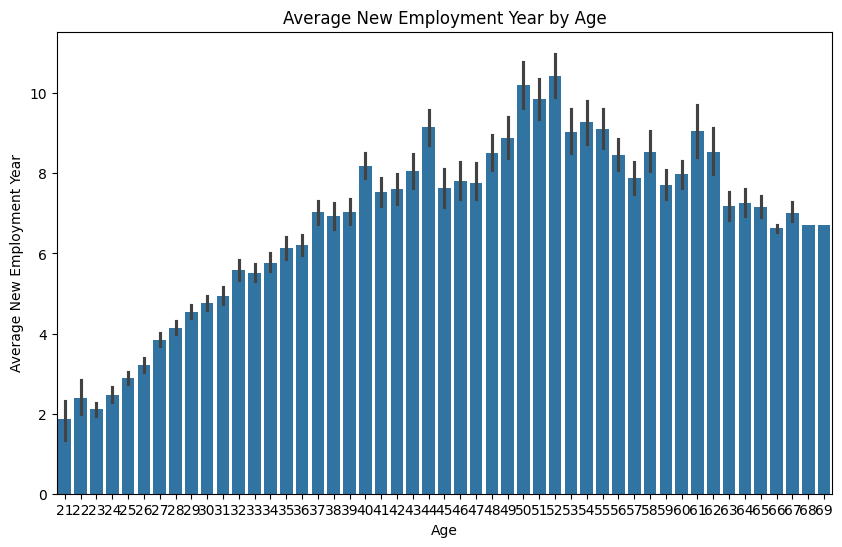

In [ ]:
# plot the Age and average new employment year
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='New Employment Year', data=dfc2)
plt.title('Average New Employment Year by Age')
plt.xlabel('Age')
plt.ylabel('Average New Employment Year')
plt.show()

In [ ]:
# Export the dfc1 DataFrame as an Excel file
output_file = "/content/drive/MyDrive/MIS561/Customers2.xlsx"
dfc2.to_excel(output_file, index=False)

print(f"'dfc2' DataFrame saved to {output_file}.")

'dfc2' DataFrame saved to /content/drive/MyDrive/MIS561/Customers2.xlsx.


# To perform the following for machine learning

To confirm:

'NAME_INCOME_TYPE'
*   Age of 'Pensioner' (to identify unexpected young one)
*   How different are they? 'Commercial associate', 'Working'




To convert to

| **Suggested Integer** | **Category**                  | **Equivalent Education Level**         | **Description**                              |
|----------------------|-------------------------------|-----------------------------------------|---------------------------------------------|
| **1**                | **Lower Secondary**            | Junior High / Middle School             | Left school before finishing high school    |
| **2**                | **Secondary / Secondary Special** | High School / Vocational School     | High school diploma or vocational certificate |
| **3**                | **Incomplete Higher**          | Partial College / University           | Attended college but did not finish         |
| **4**                | **Higher Education**           | Bachelor's Degree or equivalent        | College or university degree                |
| **5**                | **Academic Degree**            | Master's, PhD, or Professional Degree  | Postgraduate degrees (MSc, PhD, MD, etc.)   |
